# Global settings

In [1]:
# Imports
import os
import time
import uuid
import csv
import matplotlib.pyplot as plt

from datasets.data_loader import load_ppb, load_parkinson_updrs

from slim.algorithms.GP.gp import GP
from slim.algorithms.GP.operators.mutators import mutate_tree_subtree
from slim.algorithms.GP.representations.tree_utils import tree_depth, tree_pruning
from slim.config.gp_config import *
from slim.utils.logger import log_settings
from slim.utils.utils import get_terminals, validate_inputs, train_test_split


# Data load

This example runs with the Unified Parkinson's Disease Rating Scale (`parkinson_updrs`), a pre-loaded dataset. If you already have the dataset you will work with, you can do the performance tests with your own data.


In [2]:
X, y = load_parkinson_updrs(X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, p_test=0.5)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)


torch.Size([1175, 19]) torch.Size([1175, 19]) torch.Size([1175]) torch.Size([1175])


# Problem Instance

In [3]:
# Problem instance
TERMINALS = get_terminals(X_train)
pop_size = 500
init_depth = 3

gp_pi_init["TERMINALS"] = TERMINALS
gp_pi_init["init_pop_size"] = pop_size
gp_pi_init["init_depth"] = init_depth


# GP

### GP Settings

In [4]:
# GP
p_xo = 0.8
gp_parameters["p_xo"] = p_xo
gp_parameters["p_m"] = 1 - gp_parameters["p_xo"]
gp_parameters["pop_size"] = pop_size
gp_parameters["mutator"] = mutate_tree_subtree(
    gp_pi_init['init_depth'], TERMINALS, CONSTANTS, FUNCTIONS, p_c=gp_pi_init['p_c']
)


### Log settings

In [5]:
# Log
log_path = os.path.join(os.getcwd(), "log", "evaluation_n_jobs_time.csv")
if os.path.exists(log_path):
  os.remove(log_path)
    

### Solve settings

In [6]:
# Solve settings
elitism = True
n_elites = 1
algo = 'StandardGP'
# dataset_name = 'PPB'
dataset_name = 'Parkinson'
unique_run_id = uuid.uuid1()
max_depth = 17
n_iter = 1000
gp_solve_parameters['run_info'] = [algo, unique_run_id, dataset_name]
gp_solve_parameters["log_path"] = log_path
gp_solve_parameters["elitism"] = elitism
gp_solve_parameters["n_elites"] = n_elites
gp_solve_parameters["max_depth"] = max_depth
gp_solve_parameters["n_iter"] = n_iter
gp_solve_parameters["tree_pruner"] = tree_pruning(
    TERMINALS=TERMINALS, CONSTANTS=CONSTANTS, FUNCTIONS=FUNCTIONS, p_c=gp_pi_init["p_c"]
)
gp_solve_parameters['depth_calculator'] = tree_depth(FUNCTIONS=FUNCTIONS)
gp_solve_parameters["test_elite"] = True


### Experiments

In [8]:
# Solve
n_iter = 50
gp_solve_parameters["n_iter"] = n_iter

# n_jobs to be evaluated
n_jobs = [1, 2, 3, -1]

# seeds
seeds = [4, 3, 2, 1]

# Experiments
for i, n in enumerate(n_jobs):
    print('\nn_jobs: {}\n'.format(n))
    gp_solve_parameters["n_jobs"] = n
    seed = seeds[i]
    optimizer = GP(pi_init=gp_pi_init, **gp_parameters, seed=seed)
    optimizer.solve(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        curr_dataset=dataset_name,
        **gp_solve_parameters
    )



n_jobs: 1

Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     Parkinson           |       0      |   13.881887435913086  |   13.873695373535156     |   0.07156991958618164  |      3           |
|     Parkinson           |       1      |   13.881887435913086  |   13.873695373535156     |   0.045751094818115234 |      3           |
|     Parkinson           |       2      |   13.71933650970459   |   13.70920181274414      |   0.04103207588195801  |      9           |
|     Parkinson           |       3      |   12.398114204406738  |   12.279706954956055     |   0.0462336540222168   |      7           |
|    

In [9]:
# Log settings
if os.path.exists(log_path[:-4] + "_settings.csv"):
  os.remove(log_path[:-4] + "_settings.csv")

log_settings(
    path=log_path[:-4] + "_settings.csv",
    settings_dict=[gp_solve_parameters,
                   gp_parameters,
                   gp_pi_init,
                   settings_dict],
    unique_run_id=unique_run_id,
)


# Experimental results

In [10]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Solution size history
history_sizes = [int(row[9]) for row in rows]

# Runtime
history_timing = [float(row[6]) for row in rows]


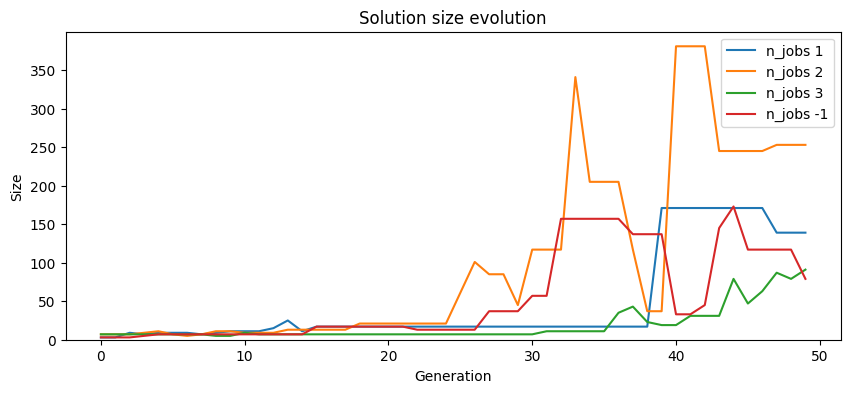

In [11]:
plt.figure(figsize=(10, 4))

for i, n in enumerate(n_jobs):
    i_start = ((gp_solve_parameters["n_iter"])*i)+i
    i_end = i_start + gp_solve_parameters["n_iter"]
    plt.plot(history_sizes[i_start:i_end], label='n_jobs '+str(n))
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.legend()
plt.savefig('./log/evaluation_n_jobs_time_size_evolution.pdf')
plt.show()


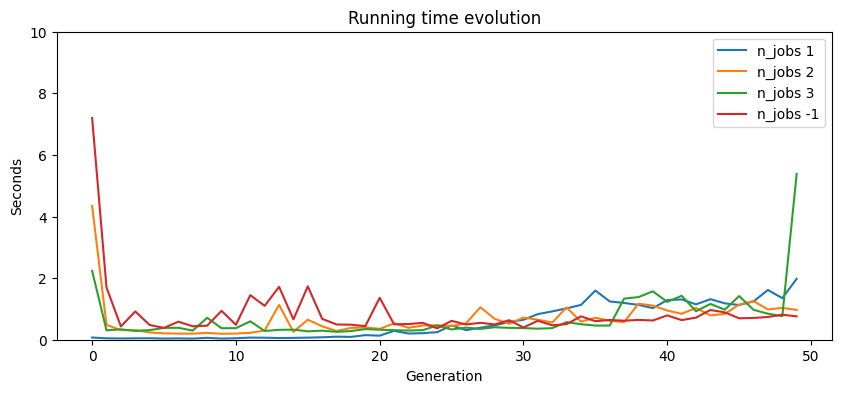

In [12]:
plt.figure(figsize=(10, 4))

for i, n in enumerate(n_jobs):
    i_start = ((gp_solve_parameters["n_iter"])*i)+i
    i_end = i_start + gp_solve_parameters["n_iter"]
    plt.plot(history_timing[i_start:i_end], label='n_jobs '+str(n))
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0, top=max(1, int(max(history_timing)*1.5)))
plt.legend()
plt.savefig('./log/evaluation_n_jobs_time_time_evolution.pdf')
plt.show()


In [14]:
for i, n in enumerate(n_jobs):
    i_start = ((gp_solve_parameters["n_iter"])*i)+i
    i_end = i_start + gp_solve_parameters["n_iter"]
    print('Total time with {} n_jobs: {:.2f} minutes.\n'.format(n, sum(history_timing[i_start:i_end])/60.))
    

Total time with 1 n_jobs: 0.48 minutes.

Total time with 2 n_jobs: 0.57 minutes.

Total time with 3 n_jobs: 0.58 minutes.

Total time with -1 n_jobs: 0.71 minutes.

